In [1]:
import torch
import numpy as np
from PIL import Image
import random
import os
from models import build_model
from config import get_config,_update_config_from_file
from dataloader import build_loader
from torchvision import transforms
from timm.data.transforms import str_to_interp_mode

In [2]:
dataset = 'cub'
split = 'test'
root_dir = '/data/tangwenhao/fgvc'
dataset_dir = os.path.join(root_dir,dataset,'data')
_dir = os.path.join(root_dir,dataset,'data',split)
for root,dirs,files in os.walk(_dir):
    _dirs = dirs
    break
cls = random.choice(_dirs)
__dir = os.path.join(_dir,cls)
for root,dirs,files in os.walk(__dir):
    _files = files

In [3]:
config = get_config(None)
config_dir = ['./configs/baseline/fgvc/cub_fgvc_vit_base_transfg.yaml',
             './configs/mim/cub_vit_mim.yaml']
for _config_dir in config_dir:
    _update_config_from_file(config,_config_dir)
config.defrost()
config.DATA.DATA_PATH = dataset_dir

=> merge config from ./configs/baseline/fgvc/cub_fgvc_vit_base_transfg.yaml
=> merge config from ./configs/mim/cub_vit_mim.yaml


In [4]:
models = build_model(config)
models['main'].eval()

MIM(
  (encoder): ViTforMiM(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        

In [15]:
a = models['main'].encoder.mask_token

In [5]:
cpt=torch.load('/data/tangwenhao/output/cub_fgvc_mim/model/mim_vit_base_patch16_224_in21k_mim_vit_e100_main_btml.pth',map_location='cpu')
models['main'].load_state_dict(cpt['state_dict'], strict=False)

<All keys matched successfully>

In [6]:
dataset_test,data_loader_test = build_loader(config=config,is_train=False)

data_loader_test = iter(data_loader_test)

(sample,targets) = next(data_loader_test)

In [7]:
transform = transforms.Compose([
                    transforms.Resize(list((np.array(config.DATA.IMG_SIZE) / config.TEST.CROP).astype(int)), str_to_interp_mode(config.DATA.INTERPOLATION)),
                    transforms.CenterCrop(config.DATA.IMG_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=torch.tensor(config.AUG.NORM[0]),
                        std=torch.tensor(config.AUG.NORM[1])
                    ),
                    ])
t_1 = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize(
                        mean=torch.tensor(config.AUG.NORM[0]),
                        std=torch.tensor(config.AUG.NORM[1])
                    )])

In [8]:
_file = random.choice(_files)
# for root,dirs,files in os.walk(__dir):
    
sample = Image.open(os.path.join(__dir,str(_file))).convert('RGB')
x = transform(sample).unsqueeze_(0)

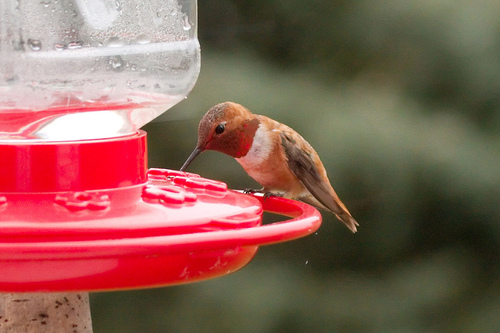

In [9]:
sample

In [10]:
with torch.no_grad():
    logits,loss_mim,x_rec=models['main'](x,True,True)

In [11]:
loss_mim

tensor(0.2413)

In [12]:
class UnNormalize:
    #restore from T.Normalize
    #反归一化
    def __init__(self,mean=(0.485, 0.456, 0.406),std= (0.229, 0.224, 0.225)):
        self.mean=torch.tensor(mean).view((1,-1,1,1))
        self.std=torch.tensor(std).view((1,-1,1,1))
    def __call__(self,x):
        _x=(x*self.std)+self.mean
        return torch.clip(_x,0,None)*255

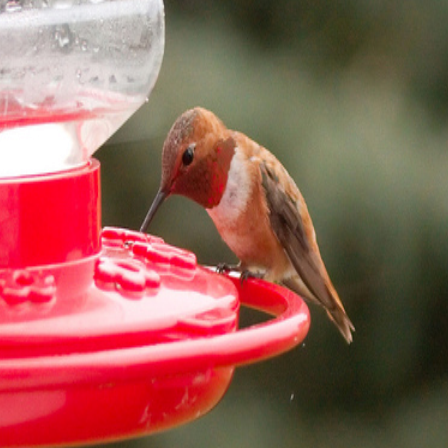

In [13]:
_i = UnNormalize()(transform(sample))[0]
_i = _i.numpy()
_i = np.moveaxis(_i,0,-1)
Image.fromarray(_i.astype('uint8')).convert('RGB')

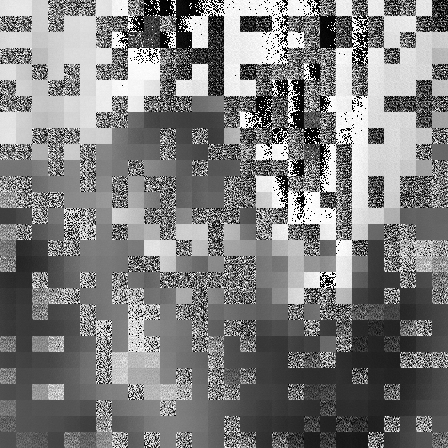

In [14]:
x_rec = UnNormalize()(x_rec)[0]
_rec = x_rec[0].numpy()
_rec = np.moveaxis(_rec,0,-1)
Image.fromarray(_rec.astype('uint8')).convert('RGB')